In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [5]:
import util
import models

from os.path import expanduser
from os import path
import logging

logging.basicConfig(level=logging.INFO)

import matplotlib.pyplot as plt
import seaborn as sns

import yass
from yass import read_config
from yass.augment import make_training_data, make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

In [6]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

In [7]:
gt = gt[2:-1]

In [8]:
gt[:, 1] = gt[:, 1] - 1

In [9]:
re = RecordingExplorer(path_to_standarized, spike_size=15)
se = SpikeTrainExplorer(gt, re)

In [10]:
def spike_amplitudes_from_spikes(spikes):
    return np.max(np.abs(spikes), axis=(0, 1))

In [11]:
amps = spike_amplitudes_from_spikes(se.templates)

In [12]:
np.argsort(amps)

array([22, 40, 46, 32, 43, 20, 21,  2, 29, 34, 12, 47, 35, 11, 14, 37, 13,
       38, 41, 39, 31, 30,  6, 10, 42, 24, 15, 45, 16,  1, 36, 44, 33, 17,
       48, 19,  0,  7, 28, 26,  4, 23, 18,  3, 25, 27,  8,  5,  9])

In [13]:
amps[[8, 5, 9]]

array([30.884478, 42.622433, 59.108902], dtype=float32)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


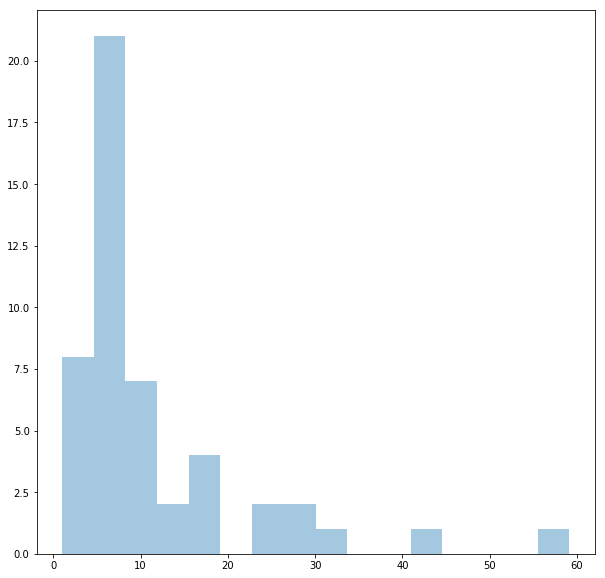

In [14]:
sns.distplot(amps, kde=False)

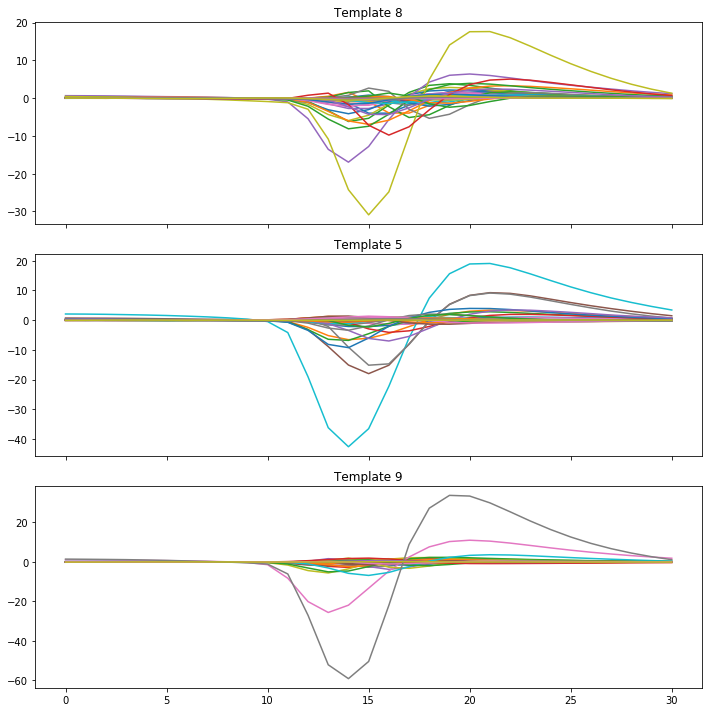

In [15]:
se.plot_templates(group_ids=[8, 5, 9])

## Generating data

In [16]:
min_amp = 5
nspikes = 50000
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

In [17]:
(x_detect,
 y_detect,
 x_triage,
 y_triage,
 x_ae,
 y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                            min_amp, nspikes,
                            data_folder='/home/Edu/data/nnet/')

100%|██████████| 113/113 [00:06<00:00, 16.79it/s]


In [18]:
x_detect.shape

(650052, 21, 7)

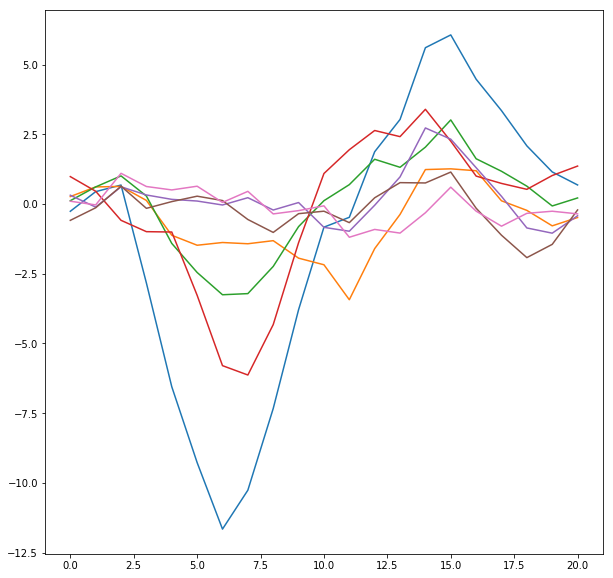

In [19]:
_ = plt.plot(x_detect[200])

In [20]:
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

In [21]:
amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


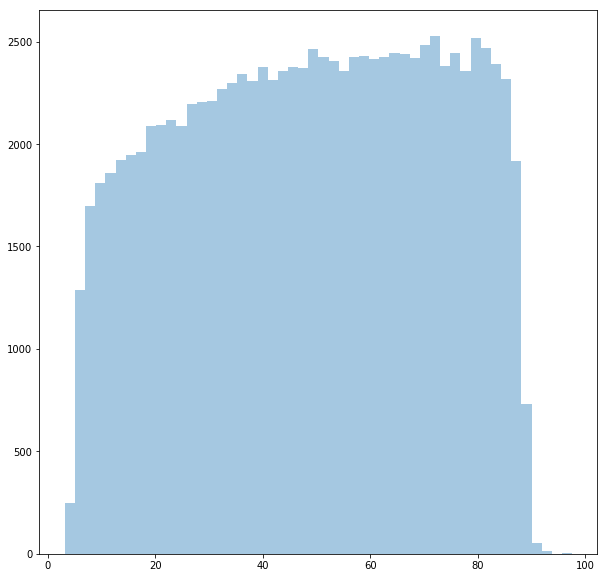

In [22]:
_ = sns.distplot(amps_positive, kde=False)

/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


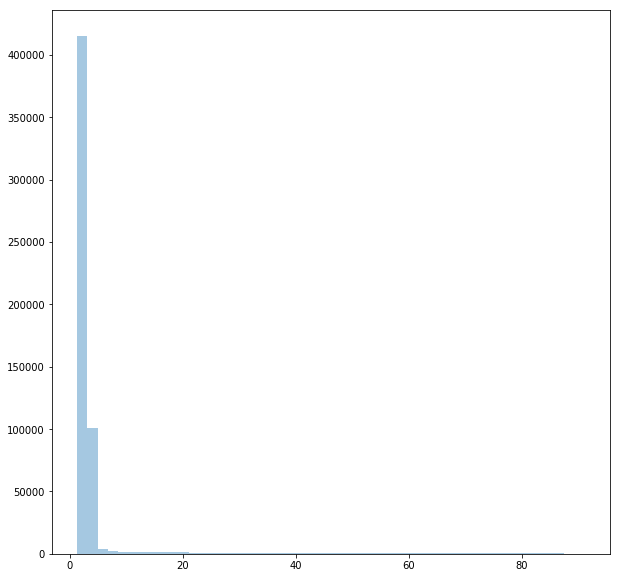

In [23]:
_ = sns.distplot(amps_negative, kde=False)

## Training detector

In [24]:
import util

In [25]:
n_iter = 5000
n_batch = 512
l2_reg_scale = 0.00000005
train_step_size =  0.001

detectnet_name = path.join('models', 'detect-'+util.directory())
n_filters_detect = [8, 4]

In [31]:
train_detector(x_detect, y_detect,
               n_filters_detect, n_iter,
               n_batch, l2_reg_scale,
               train_step_size,
               detectnet_name)



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 1/5000 [00:00<40:37,  2.05it/s]INFO:yass.augment.train_detector:Loss: 0.6845216


  1%|          | 28/5000 [00:00<28:22,  2.92it/s]

  2%|▏         | 91/5000 [00:00<19:39,  4.16it/s]

  4%|▍         | 190/5000 [00:00<13:30,  5.94it/s]

  6%|▋         | 325/5000 [00:00<09:12,  8.46it/s]

 10%|▉         | 496/5000 [00:01<06:13, 12.06it/s]

 14%|█▍        | 703/5000 [00:01<04:10, 17.18it/s]

 19%|█▉        | 946/5000 [00:01<02:45, 24.47it/s]

 24%|██▍       | 1225/5000 [00:01<01:48, 34.81it/s]

 31%|███       | 1540/5000 [00:01<01:09, 49.48it/s]

 38%|███▊      | 1891/5000 [00:01<00:44, 70.22it/s]

 46%|████▌     | 2278/5000 [00:01<00:27, 99.47it/s]

 54%|█████▍    | 2701/5000 [00:01<00:16, 140.57it/s]

 63%|██████▎   | 3160/5000 [00:01<00:09, 197.94it/s]

 73%|███████▎  | 3655/5000 [00:01<00:04, 277.49it/s]

 84%|████████▎ | 4186/5000 [00:02<00:02, 386.76it/s]

 95%|█████████▌| 4753/5000 [00:02<00:00, 535.75it/s]INFO:yass.augme



2657665it [00:42, 123020.65it/s]

2671516it [00:42, 123975.29it/s]

2685403it [00:42, 124195.51it/s]

2699326it [00:43, 124760.31it/s]

2713285it [00:43, 125306.72it/s]

2727280it [00:43, 125684.45it/s]

2741311it [00:43, 126001.74it/s]

2755378it [00:43, 126382.59it/s]

2769481it [00:43, 126381.24it/s]

2783620it [00:43, 126778.08it/s]

2797795it [00:43, 127437.54it/s]

2812006it [00:43, 127678.41it/s]

2826253it [00:43, 127932.43it/s]

2840536it [00:44, 127785.11it/s]

2854855it [00:44, 128018.98it/s]

2869210it [00:44, 129715.93it/s]

2883601it [00:44, 130067.73it/s]INFO:yass.augment.train_detector:Loss: 0.00093845604


2898028it [00:44, 130004.23it/s]

2912491it [00:44, 130707.97it/s]

2926990it [00:44, 131492.17it/s]

2941525it [00:44, 132896.14it/s]

2956096it [00:44, 133235.20it/s]

2970703it [00:45, 133043.80it/s]

2985346it [00:45, 132635.01it/s]

3000025it [00:45, 131986.94it/s]

3014740it [00:45, 133223.68it/s]

3029491it [00:45, 133651.41it/s]

3044278it [00:45, 133874.42

10513405it [01:24, 247450.48it/s]

10540936it [01:24, 248514.43it/s]

10568503it [01:24, 249770.18it/s]INFO:yass.augment.train_detector:Loss: 0.00018678722


10596106it [01:24, 249752.98it/s]

10623745it [01:24, 249567.34it/s]

10651420it [01:24, 251292.80it/s]

10679131it [01:24, 250742.38it/s]

10706878it [01:24, 249876.87it/s]

10734661it [01:25, 250426.87it/s]

10762480it [01:25, 250572.69it/s]

10790335it [01:25, 251889.87it/s]

10818226it [01:25, 249754.72it/s]

10846153it [01:25, 252697.80it/s]

10874116it [01:25, 254014.04it/s]

10902115it [01:25, 255218.39it/s]

10930150it [01:25, 253072.25it/s]

10958221it [01:25, 255009.33it/s]

10986328it [01:26, 254158.12it/s]

11014471it [01:26, 252596.56it/s]

11042650it [01:26, 251390.51it/s]INFO:yass.augment.train_detector:Loss: 0.00057827623


11070865it [01:26, 249171.52it/s]

11099116it [01:26, 250497.05it/s]

11127403it [01:26, 251846.81it/s]

11155726it [01:26, 254160.22it/s]

11184085it [01:26, 254448.79it/s]

11212480it [01:26, 

## Keras